In [1]:
import sys
sys.path.append('..')
import torch
import os
import torch.nn as nn
import torchvision
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.dataset import Dataset
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import random
from models.CycleGAN import *
from datasets.UnalignedDataset import UnalignedDataset
from utils.utils import ImageBuffer, set_requires_grad, tensor_to_image, save_cyclegan_model

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
def init_weights(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    elif isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    elif isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.normal_(m.bias, 0.0)

In [3]:
transform = transforms.Compose([transforms.Resize((140, 140), Image.BICUBIC),
                                transforms.RandomCrop(128),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

In [4]:
train_dataset = UnalignedDataset('/home/dpakhom1/Cycle_gan_pytorch/datasets/people2anime/',
                              ["trainA", "trainB"], transform=transform)
val_dataset = UnalignedDataset('/home/dpakhom1/Cycle_gan_pytorch/datasets/people2anime/',
                              ["valA", "valB"], transform=transform)

In [5]:
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=1, num_workers=2)
val_dataloader = DataLoader(val_dataset, shuffle=True, batch_size=1, num_workers=2)

<IPython.core.display.Javascript object>


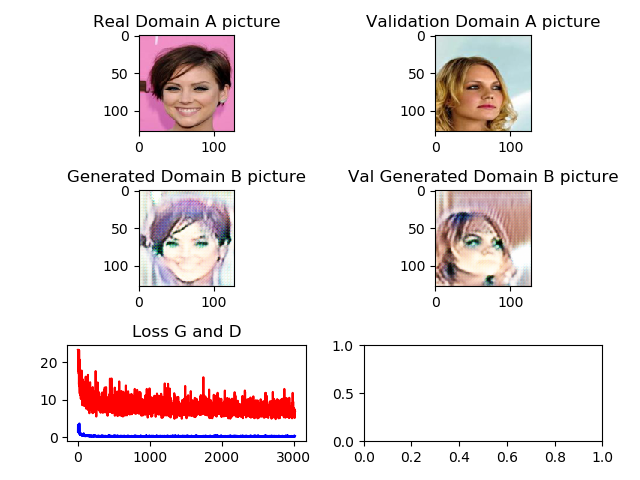

In [6]:
%matplotlib notebook
f, (real_pics, gen_pics, loss_axis) = plt.subplots(3, 2)
real_pics[0].set_title("Real Domain A picture")
gen_pics[0].set_title("Generated Domain B picture")
loss_axis[0].set_title("Loss G and D")
real_pics[1].set_title("Validation Domain A picture")
gen_pics[1].set_title("Val Generated Domain B picture")
#real_pic.plot()
#gen_pic.plot()
loss_d = []
loss_g = []
loss_axis[0].plot(loss_d, list(range(len(loss_d))), 'b',
               loss_g, list(range(len(loss_g))), 'r')
plt.tight_layout()

In [7]:
def train_loop(num_epochs, train_dataloader, G1, G2, D1, D2):
    optimizer_G = optim.Adam(list(G1.parameters()) + list(G2.parameters()), lr=0.0002, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(list(D1.parameters()) + list(D2.parameters()), lr=0.0002, betas=(0.5, 0.999))
    img_bufferA = ImageBuffer(50)
    img_bufferB = ImageBuffer(50)
    lr = 0.0002
    for epoch in range(num_epochs):

        if epoch % 50 == 49:
            save_cyclegan_model(G1, G2, D1, D2, '/home/dpakhom1/Cycle_gan_pytorch/', epoch + 1)
            
        if epoch > 100:
            for param_group in optimizer_G.param_groups:
                param_group['lr'] = max(lr - 0.00002, 0)
            for param_group in optimizer_D.param_groups:
                param_group['lr'] = max(lr - 0.00002, 0)
                
        for idx, data in enumerate(train_dataloader):
            domain_A, domain_B = data["A"].cuda(), data["B"].cuda()
            
            fake_B, cycle_BA, fake_A, cycle_AB = calc_Gs_outputs(G1, G2, domain_A, domain_B)
            
            set_requires_grad([D1, D2], False)
            optimizer_G.zero_grad()
            loss_G = backward_Gs(fake_B, cycle_BA, fake_A, cycle_AB, domain_A, domain_B, G1, G2, D1, D2)
            loss_g.append(loss_G.item())
            
            optimizer_G.step()
            #if idx % 5 == 4:
            set_requires_grad([D1, D2], True)
            optimizer_D.zero_grad()
            
            
            
            fake_A = img_bufferA.update(fake_A)
            loss_D1 = backward_D(domain_A, fake_A, D1)
            fake_B = img_bufferB.update(fake_B)
            loss_D2 = backward_D(domain_B, fake_B, D2)
            loss_d.append((loss_D1.item() + loss_D2.item())/2)
            optimizer_D.step()
            
            if idx % 200 == 199:
                print("Epoch: ", epoch + 1, "\n", "Gen loss: ", loss_G, "\n", "Discr loss: ", (loss_D1 + loss_D2)/2)

            if idx % 20 == 19:
                with torch.no_grad():
                    real_pics[0].imshow(tensor_to_image(torch.squeeze(data["A"])))
                    #real_pic.imshow(np.transpose(torch.squeeze(domain_A).cpu().detach().numpy(), (1, 2, 0)))
                    real_pics[0].relim()
                    real_pics[0].autoscale_view()
                    real_pics[0].figure.canvas.draw()
                    G1.eval()
                    output = G1(domain_A)
                    output = (((np.transpose(torch.squeeze(fake_B.detach().cpu()).numpy(), (1, 2, 0)) + 1)/2)*255).astype(np.uint8)
                    #output = transforms.ToPILImage()(torch.squeeze(fake_B.cpu())).convert("RGB")
                    gen_pics[0].imshow(output)
                    gen_pics[0].relim()
                    gen_pics[0].autoscale_view()
                    gen_pics[0].figure.canvas.draw()
                    G1.train()
                    
                    loss_axis[0].lines[0].set_xdata(list(range(len(loss_d))))
                    loss_axis[0].lines[0].set_ydata(loss_d)
                    loss_axis[0].lines[1].set_xdata(list(range(len(loss_g))))
                    loss_axis[0].lines[1].set_ydata(loss_g)
                    loss_axis[0].relim()
                    loss_axis[0].autoscale_view()
                    loss_axis[0].figure.canvas.draw()
        for data in val_dataloader:
            with torch.no_grad():
                domain_A = data["A"].cuda()
                real_pics[1].imshow(tensor_to_image(torch.squeeze(data["A"])))
                #real_pic.imshow(np.transpose(torch.squeeze(domain_A).cpu().detach().numpy(), (1, 2, 0)))
                real_pics[1].relim()
                real_pics[1].autoscale_view()
                real_pics[1].figure.canvas.draw()
                G1.eval()
                fake_B = G1(domain_A)
                output = (((np.transpose(torch.squeeze(fake_B.detach().cpu()).numpy(), (1, 2, 0)) + 1)/2)*255).astype(np.uint8)
                #output = transforms.ToPILImage()(torch.squeeze(fake_B.cpu())).convert("RGB")
                gen_pics[1].imshow(output)
                gen_pics[1].relim()
                gen_pics[1].autoscale_view()
                gen_pics[1].figure.canvas.draw()
                G1.train()
            break

In [8]:
def load_models(G1, G2, D1, D2):
    G1.load_state_dict(torch.load('./g1_good.pth'))
    G2.load_state_dict(torch.load('./g2_good.pth'))
    D1.load_state_dict(torch.load('./d1_good.pth'))
    D2.load_state_dict(torch.load('./d2_good.pth'))

In [9]:
G1 = ResnetGenerator(3, 6, norm_type='instance')
G2 = ResnetGenerator(3, 6, norm_type='instance')
D1 = PatchGan(3, norm_type='instance')
D2 = PatchGan(3, norm_type='instance')
G1.train()
G2.train()
D1.train()
D2.train()
G1 = G1.cuda()
G2 = G2.cuda()
D1 = D1.cuda()
D2 = D2.cuda()
#load_models(G1, G2, D1, D2)

In [10]:
G1.apply(init_weights);
G2.apply(init_weights);
D1.apply(init_weights);
D2.apply(init_weights);

In [ ]:
train_loop(100, train_dataloader, G1, G2, D1, D2)

/home/dpakhom1/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:  1 
 Gen loss:  tensor(11.7829, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.3057, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  1 
 Gen loss:  tensor(10.6663, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.1379, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  1 
 Gen loss:  tensor(8.5072, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.1956, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  1 
 Gen loss:  tensor(9.4484, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.1324, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  1 
 Gen loss:  tensor(7.6158, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.3377, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  2 
 Gen loss:  tensor(8.7985, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.3585, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  2 
 Gen loss:  tensor(9.4087, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss

In [28]:
def save_models(G1, G2, D1, D2):
    torch.save(G1.state_dict(), './g1_best_anime.pth')
    torch.save(G2.state_dict(), './g2_best_anime.pth')
    torch.save(D1.state_dict(), './d1_best_anime.pth')
    torch.save(D2.state_dict(), './d2_best_anime.pth')

In [29]:
save_models(G1, G2, D1, D2)